In [6]:
from os import listdir
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data source: http://web.mta.info/developers/turnstile.html
datafiles = ['../data/mta_turnstiles/' + x for x in listdir('../data/mta_turnstiles/')]

list_ = []
for file_ in datafiles:
    df = pd.read_csv(file_)
    list_.append(df)
frame = pd.concat(list_)
frame.rename(columns=lambda x: x.strip())


datetimes = []
for index, row in frame.iterrows():
    dstr = row['DATE'] + ' ' + row['TIME']
    datetimes.append(datetime.strptime(dstr, '%m/%d/%Y %H:%M:%S'))
date_min = min(datetimes)
date_max = max(datetimes)
# frame['DATETIME'] = datetimes
# del frame['DATE']
# del frame['TIME']

print frame.shape
frame.head(10)

# Slice a limited sample to speed up processing
# frame = frame[:50000]

(777253, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,00:00:00,REGULAR,5672118,1920707
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,04:00:00,REGULAR,5672183,1920719
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,08:00:00,REGULAR,5672214,1920761
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,12:00:00,REGULAR,5672330,1920867
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,16:00:00,REGULAR,5672640,1920936
5,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,20:00:00,REGULAR,5673031,1921000
6,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,00:00:00,REGULAR,5673268,1921052
7,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,04:00:00,REGULAR,5673298,1921061
8,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,08:00:00,REGULAR,5673312,1921080
9,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,12:00:00,REGULAR,5673379,1921156


In [3]:
# Build dictionary for challenge 1

device_audits = defaultdict(list)

for index, row in frame.iterrows():
    device_audits[tuple(row[0:4])].append(row[4:].tolist())
    
print len(device_audits)


4603


In [4]:
# Build dictionary for challenge 2
# datetime, entries

# Get all audits
device_audits = defaultdict(list)

for index, row in frame.iterrows():
    dstr = row['DATE'] + ' ' + row['TIME']
    datetime = datetime.strptime(dstr, '%m/%d/%Y %H:%M:%S')
    en = row[u'ENTRIES']
    device_audits[tuple(row[0:4])].append([datetime,en])
    
print len(device_audits)


# Change audits to counts by subtracting values
device_counts = {device: 
                 [(row[i][0], 
                   row[i+1][0] - row[i][0], 
                   row[i+1][1] - row[i][1]) for i in range(len(row)-1)]
                  for device, row in device_audits.iteritems()}

4603


In [7]:
# Look at counts
all_counts = [count for rows in device_counts.values() for (_, _, count) in rows]
all_counts.sort()
print all_counts[-50:]
print all_counts[:120]

# Look at durations
all_times = [duration.total_seconds() / 60 / 60
             for rows in device_counts.values()
             for _, duration, _ in rows]
print Counter(all_times).most_common(10)

# Remove bad counts
datetime_counts = {turnstile: [(time, count)
                               for (time, _, count) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in device_counts.items()}

# Look at good counts
all_good_counts = [count for rows in datetime_counts.values() for _, count in rows]
print float(len(all_good_counts)) / len(all_counts)

all_good_counts.sort()
print all_good_counts[-5:]
print all_good_counts[:5]

[3033, 3060, 3076, 3096, 3116, 3125, 3168, 3206, 3242, 3320, 3321, 3355, 3367, 3378, 3735, 3768, 4203, 4545, 4695, 5058, 5068, 6078, 6440, 6625, 7370, 7554, 7726, 9003, 10289, 13286, 17168, 17720, 66568, 261543, 393174, 1291975, 1629370, 2402797, 2557082, 2557829, 49514290, 83519145, 116224139, 117416496, 117439681, 317504870, 519992536, 1403818353, 1879007766, 2076115187]
[-1609769922, -1409336682, -519992452, -302009169, -151085187, -117416496, -50370646, -16810693, -14151887, -8092732, -6450530, -6249543, -4313168, -3152690, -2886522, -2754015, -2728372, -2557080, -2556224, -2234351, -2130307, -2082158, -1933256, -1693086, -1629062, -1303776, -1153863, -853125, -801481, -725861, -557859, -530089, -527759, -515629, -393172, -326195, -297769, -281880, -202674, -183043, -174839, -170770, -135440, -105170, -102445, -80768, -78879, -68579, -66457, -46765, -31435, -18659, -17720, -16431, -14866, -11540, -11191, -8197, -3168, -2682, -2393, -2288, -2060, -1993, -1968, -1932, -1902, -1894, -

## Times

Audits are usually taken every 4 hours, but there are also irregular audits in the data.  The DESC variable indicates whether a particular audit was taken regularly or not (http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt).  Samples may be taken irregularly due to planning or troubleshooting activities.

In [8]:
print "Count of audit types"
for s in set(frame["DESC"]):
    ct = frame["DESC"].tolist().count(s)
    print "%s: %d"%(s,ct)

Count of audit types
REGULAR: 774162
RECOVR AUD: 3091


In [9]:
# Challenge 3

# Collapse a list of audits so that all audits on the same are combined into one
def collapse_days(l):
    day_entries = []
    dayset = sorted(set([x[0].date() for x in l]))
    for day in dayset:
        entries = sum([x[1] for x in l if x[0].date() == day])
        day_entries.append((day, entries))
    return day_entries

device_counts_daily = defaultdict(list)
for key,value in datetime_counts.iteritems():
    device_counts_daily[key] = collapse_days(value)
    
print device_counts_daily.iteritems().next()




(('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD'), [(datetime.date(2016, 5, 21), 820), (datetime.date(2016, 5, 22), 640), (datetime.date(2016, 5, 23), 1533), (datetime.date(2016, 5, 24), 1502), (datetime.date(2016, 5, 25), 1593), (datetime.date(2016, 5, 26), 1638), (datetime.date(2016, 5, 27), 1455), (datetime.date(2016, 5, 28), 784), (datetime.date(2016, 5, 29), 660), (datetime.date(2016, 5, 30), 701), (datetime.date(2016, 5, 31), 1381), (datetime.date(2016, 6, 1), 1490), (datetime.date(2016, 6, 2), 1462), (datetime.date(2016, 6, 3), 1522), (datetime.date(2016, 6, 4), 846), (datetime.date(2016, 6, 5), 615), (datetime.date(2016, 6, 6), 1461), (datetime.date(2016, 6, 7), 1643), (datetime.date(2016, 6, 8), 1508), (datetime.date(2016, 6, 9), 1460), (datetime.date(2016, 6, 10), 1452), (datetime.date(2016, 6, 11), 794), (datetime.date(2016, 6, 12), 638), (datetime.date(2016, 6, 13), 1505), (datetime.date(2016, 6, 14), 1544), (datetime.date(2016, 6, 15), 1532), (datetime.date(2016, 6, 16), 1262

('H019', 'R294', '00-06-00', 'MORGAN AV')


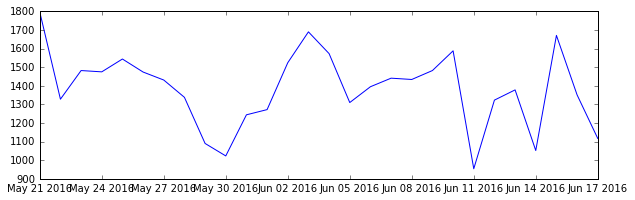

In [10]:
# Challenge 4

%matplotlib inline


turnstiles = device_counts_daily.iteritems()
for i in range(19):
    stile = turnstiles.next()

print stile[0]
ts_data = np.array(stile[1])

dates = ts_data[:,0]
counts = ts_data[:,1]

plt.figure(figsize=(10,3))
plt.plot(dates,counts)

In [12]:
# Standardize data into standardized shift samples

turnstiles = datetime_counts.iteritems()
turnstile_shifts = []

# Make list of standardized times
time_max = float((date_max - date_min).total_seconds())
standard_times = np.arange(0.0, time_max, step=float(3600*4))

for stile in turnstiles:
    ts_data = np.array(stile[1])
    
    if ts_data.shape[0] < 10:
        continue
    
    dates = ts_data[:,0]
    counts = map(float, ts_data[:,1])
    
    # Convert each time into seconds since begnning of sample
    diff_sec = lambda x: float((x - date_min).total_seconds())
    time_seconds = map(diff_sec, dates)
    
    counts_4hours = np.interp(standard_times, time_seconds, counts, left=0, right=0)
    
    for (t,c) in zip(standard_times, counts_4hours):
        turnstile_shifts.append((stile[0], t, c))
        
turnstile_shifts = np.array(turnstile_shifts)



In [13]:
# Combine turnstiles into stations
daycodes = ['MO','TU','WE','TH','FR','SA','SU']
station_shifts_dict = dict()
for s in turnstile_shifts:
    dt = timedelta(seconds=(float(s[1]))) + date_min
    wkdy = daycodes[dt.weekday()]
    tm = dt.hour
    daytime = wkdy + str(tm)
    
    key = (s[0][3], daytime)
    station_shifts_dict[key] = station_shifts_dict.get(key, 0) + s[2]

station_shifts = []
for key, val in station_shifts_dict.items():
    station_shifts.append(list(key + (val,)))


# for sh in station_shifts:
#     dt = timedelta(seconds=(float(sh[1]))) + date_min
#     wkdy = daycodes[dt.weekday()]
#     tm = dt.hour
#     sh[1] = wkdy + str(tm)

In [15]:
# Print best shifts
station_shifts = np.array(station_shifts)

best_shifts = np.argsort(station_shifts[:,2].astype(float))[::-1]
station_shifts[best_shifts[:5]]

array([['GRD CNTRL-42 ST', 'WE16', '264820.75'],
       ['GRD CNTRL-42 ST', 'TU16', '261156.635088'],
       ['GRD CNTRL-42 ST', 'TH16', '253392.75'],
       ['34 ST-PENN STA', 'TU8', '217733.283784'],
       ['34 ST-HERALD SQ', 'WE16', '215555.0'],
       ['34 ST-HERALD SQ', 'TH16', '214888.0'],
       ['34 ST-PENN STA', 'TH8', '211538.486486'],
       ['GRD CNTRL-42 ST', 'FR16', '210834.0'],
       ['34 ST-HERALD SQ', 'TU16', '210673.0'],
       ['GRD CNTRL-42 ST', 'MO16', '202593.607143'],
       ['34 ST-PENN STA', 'WE8', '197999.029961'],
       ['23 ST', 'TH16', '196266.75'],
       ['23 ST', 'WE16', '195875.5'],
       ['23 ST', 'TU16', '193184.25'],
       ['34 ST-HERALD SQ', 'FR16', '189803.222222'],
       ['34 ST-PENN STA', 'TH16', '188432.77027'],
       ['34 ST-PENN STA', 'WE16', '186432.918919'],
       ['34 ST-PENN STA', 'FR8', '181925.054054'],
       ['34 ST-PENN STA', 'TU16', '181259.567568'],
       ['34 ST-HERALD SQ', 'MO16', '176165.0'],
       ['TIMES SQ-42 ST', 'W

In [49]:
# Load match list: dictionary with keys as names of turnstile stations, vals as Max stations
station_pairs = dict()
with open('../data/turnstile_pairs.csv','r') as f:
    for line in f:
        line = line.rstrip().split(',')
        if len(line)<2:
            continue
        if len(line)>2:
            print line
        st1s = line[0].split('?')
        st2 = line[1].split('?')[0]
        for st1 in st1s:
            station_pairs[st1] = st2

# Load max's data
station_poi = []
with open('../data/poi/stationTargetProxy.csv','r') as f:
    f.next()
    for line in f:
        line = line.split(',')
        line = line[:1] + map(int, line[1:])
        station_poi.append(line)
    


In [56]:
turn_stations = list(set(station_shifts[:,0]))
poi_stations = [x[0] for x in station_poi]

poi = dict()
usable_stations = []
for st1 in turn_stations:
    if st1 in station_pairs:
        st2 = station_pairs[st1]
        
        max_ind = poi_stations.index(st2)
        
        poi[st1] = station_poi[max_ind]
        usable_stations.append(st1)

print poi[turn_stations[0]]

['CYPRESS AV', 3, 1, 4]


In [63]:
# Print best shifts
shift_scores = []
for s in usable_stations:
    
    schct = poi[s][1]
    busct = poi[s][2]
    
    ss = station_shifts[turn_stations.index(s)]
    trafc = float(ss[2])
    
    score = 0.25*schct + 0.25*busct/10 + 0.5*trafc/100000
    
    shift_scores.append((ss[0],ss[1],score, schct, busct, trafc))
    
shift_scores = np.array(shift_scores)
best_shifts = np.argsort(shift_scores[:,2].astype(float))[::-1]
shift_scores[best_shifts[:25]]

array([['BOWLING GREEN', 'TH8', '7.73855', '13', '175', '22710.0'],
       ['65 ST', 'TH0', '7.52609875', '13', '171', '219.75'],
       ['80 ST', 'WE12', '7.46492625', '13', '168', '2985.25'],
       ['174 ST', 'SA4', '7.28777875', '12', '171', '2555.75'],
       ['BEDFORD PK BLVD', 'TH4', '7.10554', '11', '171', '16108.0'],
       ['BEACH 60 ST', 'FR16', '6.85827', '10', '174', '1654.0'],
       ['85 ST-FOREST PK', 'TH0', '6.701075', '11', '158', '215.0'],
       ['20 AV', 'SA16', '6.4889725', '13', '129', '2794.5'],
       ['BRIGHTON BEACH', 'MO4', '6.47068', '12', '137', '9136.0'],
       ['5 AVE', 'SA12', '6.348425', '11', '143', '4685.0'],
       ['UTICA AV', 'TU4', '4.9903135', '7', '126', '18062.7'],
       ['AQUEDUCT RACETR', 'TU12', '4.88131', '7', '125', '1262.0'],
       ['STEINWAY ST', 'TH8', '4.870285', '10', '91', '19057.0'],
       ['ELMHURST AV', 'TH0', '4.177597', '6', '107', '519.4'],
       ['BROOKLYN BRIDGE', 'SA20', '3.85071', '11', '43', '5142.0'],
       ['PARKC